In [1]:
import os
import sys

import logging
import re
import pathlib

import datetime

import numpy as np
import pandas as pd
from scipy.stats import pearsonr

import matplotlib.pyplot as plt

from pyplink import PyPlink
import seaborn as sns

import statsmodels.api as sm

import matplotlib.patches as patches
import matplotlib

from basic_tools import *

"""

jupyter nbconvert 5_association.ipynb --to script
python 5_association.py albumin 2 0

for i in {00..101};do python 5_association.py $i 2 1;done


for i in {00..10};do python 5_association.py $i 2 0;done
for i in {11..20};do python 5_association.py $i 2 0;done
for i in {21..30};do python 5_association.py $i 2 0;done
for i in {31..40};do python 5_association.py $i 2 0;done
for i in {41..50};do python 5_association.py $i 2 0;done
for i in {51..60};do python 5_association.py $i 2 0;done
for i in {61..70};do python 5_association.py $i 2 0;done
for i in {71..80};do python 5_association.py $i 2 0;done
for i in {91..90};do python 5_association.py $i 2 0;done
for i in {91..101};do python 5_association.py $i 2 0;done
for i in {51..60};do python 5_association.py $i 2 0;done
for i in {51..60};do python 5_association.py $i 2 0;done
for i in {51..60};do python 5_association.py $i 2 0;done

for i in {00..101};do python 5_association.py $i 1 0,2;done
for i in {00..101};do python 5_association.py $i 1 1;done

for i in {00..20};do python 5_association.py $i 1 1;done
for i in {21..40};do python 5_association.py $i 1 1;done
for i in {41..60};do python 5_association.py $i 1 1;done
for i in {61..80};do python 5_association.py $i 1 1;done
for i in {81..101};do python 5_association.py $i 1 1;done

"""

'\n\njupyter nbconvert 5_association.ipynb --to script\npython 5_association.py albumin 2 0\n\nfor i in {00..101};do python 5_association.py $i 2 1;done\n\n\nfor i in {00..10};do python 5_association.py $i 2 0;done\nfor i in {11..20};do python 5_association.py $i 2 0;done\nfor i in {21..30};do python 5_association.py $i 2 0;done\nfor i in {31..40};do python 5_association.py $i 2 0;done\nfor i in {41..50};do python 5_association.py $i 2 0;done\nfor i in {51..60};do python 5_association.py $i 2 0;done\nfor i in {61..70};do python 5_association.py $i 2 0;done\nfor i in {71..80};do python 5_association.py $i 2 0;done\nfor i in {91..90};do python 5_association.py $i 2 0;done\nfor i in {91..101};do python 5_association.py $i 2 0;done\nfor i in {51..60};do python 5_association.py $i 2 0;done\nfor i in {51..60};do python 5_association.py $i 2 0;done\nfor i in {51..60};do python 5_association.py $i 2 0;done\n\nfor i in {00..101};do python 5_association.py $i 1 0,2;done\nfor i in {00..101};do py

In [2]:
plink_KCHIP_HLA_AA_SNP_1000G=PyPlink(plink_KCHIP_HLA_AA_SNP_1000G_path)
plink_KCHIP_HLA_AA_SNP_1000G_fam=plink_KCHIP_HLA_AA_SNP_1000G.get_fam().astype({'fid':str,'iid':str}).rename(columns={'fid':'FID','iid':'IID'})
plink_KCHIP_HLA_AA_SNP_1000G_bim=plink_KCHIP_HLA_AA_SNP_1000G.get_bim()

In [3]:
phenotypes=pd.read_csv(pheno_all_file_path,sep='\t')
phenotypes=phenotypes.set_index('ID').loc[plink_KCHIP_HLA_AA_SNP_1000G_fam['IID']]

binary_continuous_traits=phenotypes.columns.difference(['age','sex','cohort','diabetes'])

In [4]:
gene_bed_path='data/mart_export.txt'
gene_bed=pd.read_csv(gene_bed_path,sep='\t')
gene_bed=gene_bed.drop(columns='Exon stable ID')
gene_bed=gene_bed[(gene_bed['Gene start (bp)']>=plink_KCHIP_HLA_AA_SNP_1000G_bim.pos.min())&(gene_bed['Gene end (bp)']<=plink_KCHIP_HLA_AA_SNP_1000G_bim.pos.max())]
gene_bed=gene_bed[(gene_bed['Transcript type']=='protein_coding')]
gene_bed=gene_bed[~gene_bed.duplicated(['Gene name','Gene start (bp)','Gene end (bp)'])]
print(gene_bed.shape)
gene_bed=gene_bed[~gene_bed.duplicated(['Gene name'])]
print(gene_bed.shape)

gene_assign=plink_KCHIP_HLA_AA_SNP_1000G_bim[['pos']]

for idx,row in gene_bed.iterrows():
    gene_assign[row['Gene name']]=0
    
for idx,row in gene_bed.iterrows():    
    gene_assign[row['Gene name']][(gene_assign['pos']>=row['Gene start (bp)'])&(gene_assign['pos']<=row['Gene end (bp)'])]=1

#gene_assign.columns=gene_assign.columns.str.replace('HLA-','HLA_')        
    
HLA_names=np.unique([i[0].split('_')[1] for i in plink_KCHIP_HLA_AA_SNP_1000G_bim[plink_KCHIP_HLA_AA_SNP_1000G_bim.index.str.contains('HLA_')].index.str.split('*')])

for HLA_name in HLA_names:
    gene_select=gene_assign[gene_assign.index.str.contains('HLA_'+HLA_name)|gene_assign.index.str.contains('SNPS_'+HLA_name)|gene_assign.index.str.contains('AA_'+HLA_name)]#print(gene_select.sort_values('pos').iloc[0],gene_select.sort_values('pos').iloc[-1])
    HLA_name='HLA-{}'.format(HLA_name)
    gene_assign[HLA_name][(gene_assign['pos']>=gene_select['pos'].min())&(gene_assign['pos']<=gene_select['pos'].max())]=1 


(209, 30)
(207, 30)


/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [5]:
#gene_assign.iloc[:,gene_assign.columns.str.contains('HLA')]
#gene_bed[gene_bed['Gene name'].str.contains('HLA')]

In [6]:
plt.rcParams["figure.figsize"] = (20,5)
plt.rcParams["font.size"] = 15
plt.rcParams['font.family']='Arial'


for phenotype_name in binary_continuous_traits:
    if phenotype_name not in ['glucose_in_blood','blood_in_urine','t2_diabetes']:
        continue
    print(phenotype_name)
    data_out_assoc_phenotype_path=data_out_assoc_path+phenotype_name+'/'
    pheno=pd.read_csv(data_out_pheno_path+phenotype_name+'.phe',sep='\t',names=['FID','IID','pheno'])
    
    phenotype_type='binary' if len(pheno['pheno'][pheno['pheno']!=-9].value_counts())<3 else 'continuous'    
    
    for step_idx_sub in range(1,100):
        print(step_idx_sub,end=' ')
        plt.clf()
        #print(step_idx_sub)
        if os.path.exists(data_out_assoc_phenotype_path+'step_{:02d}.cond.stop'.format(step_idx_sub)):
            print('meets end',step_idx_sub)
            break
        result_merge=pd.read_csv(data_out_assoc_phenotype_path+'step_{:02d}.merge.result.tsv'.format(step_idx_sub),sep='\t')

        
        
        ##########################################
        #############Plotting#####################
        ##########################################

        data=result_merge[['marker_name','POS','P']].copy()



        data['-log10_P']=-np.log10(data['P'])
        data['size']=-np.log10(data['P'])*5
        data['size']=350*(data['size']-data['size'].min())/(data['size'].max()-data['size'].min())+0.001

        POS_MB_min=27.9
        POS_MB_max=35.1


        tick_pad=20
        gene_annot_pad=data['-log10_P'].max()/30
        gene_annot_height=data['-log10_P'].max()/30

        data['POS_MB']=data['POS']/1000000
        data['check']=False

        data=data.sort_values('P',ascending=False).reset_index()

        ax = plt.subplot(111)


        data_select_list=[]

        for gene_name in ['HLA-A','HLA-B','HLA-C']:
            pos_min=gene_assign[gene_assign[gene_name]==1]['pos'].min()/1000000
            pos_max=gene_assign[gene_assign[gene_name]==1]['pos'].max()/1000000
            color='#fa3c14'

            rect = patches.Rectangle((pos_min,-gene_annot_height-gene_annot_pad),pos_max-pos_min,gene_annot_height,linewidth=1,edgecolor=None,facecolor=color)
            ax.add_patch(rect)
            #plt.annotate(gene_name.replace('_','-'),xy=((pos_min+pos_max)/2,-5),xytext=((pos_min+pos_max)/2,-10),fontsize=3,ha='center',arrowprops=dict(arrowstyle="- >",connectionstyle="arc3,rad=0",ls='dashed'))#,bbox= dict(boxstyle="round,pad=0.3", fc=(1,1,1,0.5), ec="black", lw=0.3),size=15)

            select=(data['POS_MB']>pos_min)&(data['POS_MB']<pos_max)&(data['check']==False)
            data.loc[select,'check']=True
            data_select=data.loc[select].copy()   
            data_select['color']=color

            data_select_list.append(data_select.sort_values('-log10_P'))



        for gene_name in ['HLA-DPA1', 'HLA-DPB1','HLA-DQA1', 'HLA-DQB1','HLA-DRB1','HLA-DRA']:
            pos_min=gene_assign[gene_assign[gene_name]==1]['pos'].min()/1000000
            pos_max=gene_assign[gene_assign[gene_name]==1]['pos'].max()/1000000
            color='#2850c8'

            rect = patches.Rectangle((pos_min,-gene_annot_height-gene_annot_pad),pos_max-pos_min,gene_annot_height,linewidth=1,edgecolor=None,facecolor=color)
            ax.add_patch(rect)
            #plt.annotate(gene_name.replace('_','-'),xy=((pos_min+pos_max)/2,-5),xytext=((pos_min+pos_max)/2,-10),fontsize=3,ha='center',arrowprops=dict(arrowstyle="- >",connectionstyle="arc3,rad=0",ls='dashed'))#,bbox= dict(boxstyle="round,pad=0.3", fc=(1,1,1,0.5), ec="black", lw=0.3),size=15)

            select=(data['POS_MB']>pos_min)&(data['POS_MB']<pos_max)&(data['check']==False)
            data.loc[select,'check']=True
            data_select=data.loc[select].copy()       
            data_select['color']=color
            data_select_list.append(data_select.sort_values('-log10_P'))


        #for gene_name in gene_assign.columns[gene_assign.columns.str.contains('HLA')].difference(['HLA_A','HLA_B','HLA_C','HLA_DPA1','HLA_DPB1','HLA_DQA1', 'HLA_DQB1', 'HLA_DRB1','HLA-DRA']):#['HLA_A29.1']):
        for gene_name in ['HLA-F', 'HLA-G', 'HLA-E', 'HLA-DRB5', 'HLA-DQA2', 'HLA-DQB2', 'HLA-DOB', 'HLA-DMB', 'HLA-DMA', 'HLA-DOA', 'MICA','MICB','TAP2','TAP1']:
        #for gene_name in ['HLA-F', 'HLA-G',  'HLA-E', 'HLA-DRB5','HLA-DMB', 'HLA-DMA', 'HLA-DOA', 'HLA-DOB','HLA-DQA2', 'HLA-DQB2']:
            pos_min=gene_assign[gene_assign[gene_name]==1]['pos'].min()/1000000
            pos_max=gene_assign[gene_assign[gene_name]==1]['pos'].max()/1000000
            color='#28c828'

            rect = patches.Rectangle((pos_min,-gene_annot_height-gene_annot_pad),pos_max-pos_min,gene_annot_height,linewidth=1,edgecolor=None,facecolor=color)
            ax.add_patch(rect)
            #plt.annotate(gene_name.replace('_','-'),xy=((pos_min+pos_max)/2,-5),xytext=((pos_min+pos_max)/2,-10),fontsize=3,ha='center',arrowprops=dict(arrowstyle="- >",connectionstyle="arc3,rad=0",ls='dashed'))#,bbox= dict(boxstyle="round,pad=0.3", fc=(1,1,1,0.5), ec="black", lw=0.3),size=15)


            select=(data['POS_MB']>pos_min)&(data['POS_MB']<pos_max)&(data['check']==False)
            data.loc[select,'check']=True
            data_select=data.loc[select].copy()       
            data_select['color']=color
            data_select_list.append(data_select.sort_values('-log10_P'))  


        for gene_name in gene_assign.columns[~gene_assign.columns.str.contains('HLA')]:
            #print(gene_name)
            pos_min=gene_assign[gene_assign[gene_name]==1]['pos'].min()/1000000
            pos_max=gene_assign[gene_assign[gene_name]==1]['pos'].max()/1000000
            color='#fafac8'
            #color=matplotlib.colors.rgb2hex(0.5*np.array(plt.cm.rainbow(np.random.rand())[:3]))
            rect = patches.Rectangle((pos_min,-gene_annot_height-gene_annot_pad),pos_max-pos_min,gene_annot_height,linewidth=1,edgecolor='grey',facecolor=color,alpha=0.5)
            #rect = patches.Rectangle((pos_min,-5.5),pos_max-pos_min,3,linewidth=1,edgecolor='grey',facecolor=color,alpha=0.5)
            ax.add_patch(rect)
            #plt.annotate(gene_name.replace('_','-'),xy=((pos_min+pos_max)/2,-5),xytext=((pos_min+pos_max)/2,-10),fontsize=3,ha='center',arrowprops=dict(arrowstyle="- >",connectionstyle="arc3,rad=0",ls='dashed'))#,bbox= dict(boxstyle="round,pad=0.3", fc=(1,1,1,0.5), ec="black", lw=0.3),size=15)


            select=(data['POS_MB']>pos_min)&(data['POS_MB']<pos_max)&(data['check']==False)
            data.loc[select,'check']=True
            data_select=data.loc[select].copy()       
            data_select['color']=color
            data_select_list.append(data_select.sort_values('-log10_P'))     


        color='#fafac8'
        select=(data['check']==False)
        data.loc[select,'check']=True
        data_select=data.loc[select].copy()    
        data_select['color']=color
        data_select_list.append(data_select.sort_values('-log10_P'))  
        #data_select=data.loc[select].sort_values('-log10_P')
        #plt.scatter(x=data_select['POS_MB'],y=data_select['-log10_P'],sizes=data_select['size'],marker='d',linewidth=0.3,edgecolor='black',color=color)   

        for data_select in data_select_list[::-1]:
            plt.scatter(x=data_select['POS_MB'],y=data_select['-log10_P'],sizes=data_select['size'],marker='d',linewidth=0.3,edgecolor='black',color=data_select['color'])   



        plt.plot(np.linspace(POS_MB_min,POS_MB_max,100),-np.log10(5e-8)*np.ones_like(np.linspace(POS_MB_min,POS_MB_max,100)),'--',color='black',alpha=0.7,linewidth=0.7)    
        #ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)  
        ax.spines['bottom'].set_position('zero')#ax.spines['bottom'].set_visible(False) 

        ax.tick_params(axis='x', which='major', pad=tick_pad)

        plt.xlim(POS_MB_min,POS_MB_max)
        #ax.set_ylim(bottom=0.)
        #ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        #plt.savefig('savefig_polygenicity.png',bbox_inches="tight")        
        
        
        ##########################################
        #############Plotting#####################
        ##########################################
        #plt.savefig('savefig_polygenicity.png',bbox_inches="tight") 
        #plt.show()
        plt.savefig(data_out_assoc_phenotype_path+'step_{:02d}.merge.manhattan.png'.format(step_idx_sub),bbox_inches="tight")
        #plt.show()
        #break
    #break

blood_in_urine
1 

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2 

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3 meets end 3
glucose_in_blood
1 

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2 

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3 meets end 3
t2_diabetes
1 

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2 

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3 meets end 3


<Figure size 1440x360 with 0 Axes>

tar -czvf s_gwas_all.tar data/out_assoc/*/*merge*.png
tar -czvf s_figure_manhattan.tar data/out_assoc/*/*merge*

(27.9, 35.1)

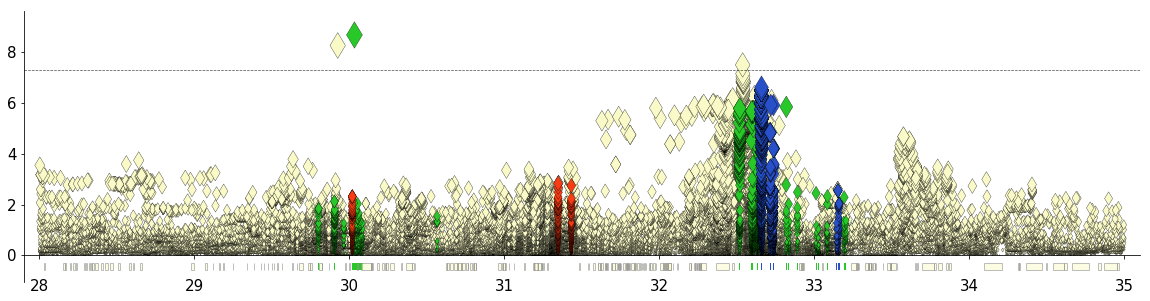

In [176]:


data=result_merge[['marker_name','POS','P']].copy()



data['-log10_P']=-np.log10(data['P'])
data['size']=-np.log10(data['P'])*5
data['size']=350*(data['size']-data['size'].min())/(data['size'].max()-data['size'].min())+0.001

POS_MB_min=27.9
POS_MB_max=35.1


tick_pad=20
gene_annot_pad=data['-log10_P'].max()/30
gene_annot_height=data['-log10_P'].max()/30

data['POS_MB']=data['POS']/1000000
data['check']=False

data=data.sort_values('P',ascending=False).reset_index()

ax = plt.subplot(111)


data_select_list=[]

for gene_name in ['HLA_A','HLA_B','HLA_C']:
    pos_min=gene_assign[gene_assign[gene_name]==1]['pos'].min()/1000000
    pos_max=gene_assign[gene_assign[gene_name]==1]['pos'].max()/1000000
    color='#fa3c14'

    rect = patches.Rectangle((pos_min,-gene_annot_height-gene_annot_pad),pos_max-pos_min,gene_annot_height,linewidth=1,edgecolor=None,facecolor=color)
    ax.add_patch(rect)
    #plt.annotate(gene_name.replace('_','-'),xy=((pos_min+pos_max)/2,-5),xytext=((pos_min+pos_max)/2,-10),fontsize=3,ha='center',arrowprops=dict(arrowstyle="- >",connectionstyle="arc3,rad=0",ls='dashed'))#,bbox= dict(boxstyle="round,pad=0.3", fc=(1,1,1,0.5), ec="black", lw=0.3),size=15)
    
    select=(data['POS_MB']>pos_min)&(data['POS_MB']<pos_max)&(data['check']==False)
    data.loc[select,'check']=True
    data_select=data.loc[select].copy()   
    data_select['color']=color
    
    data_select_list.append(data_select.sort_values('-log10_P'))
 


for gene_name in ['HLA_DPA1','HLA_DPB1','HLA_DQA1', 'HLA_DQB1', 'HLA_DRB1']:
    pos_min=gene_assign[gene_assign[gene_name]==1]['pos'].min()/1000000
    pos_max=gene_assign[gene_assign[gene_name]==1]['pos'].max()/1000000
    color='#2850c8'

    rect = patches.Rectangle((pos_min,-gene_annot_height-gene_annot_pad),pos_max-pos_min,gene_annot_height,linewidth=1,edgecolor=None,facecolor=color)
    ax.add_patch(rect)
    #plt.annotate(gene_name.replace('_','-'),xy=((pos_min+pos_max)/2,-5),xytext=((pos_min+pos_max)/2,-10),fontsize=3,ha='center',arrowprops=dict(arrowstyle="- >",connectionstyle="arc3,rad=0",ls='dashed'))#,bbox= dict(boxstyle="round,pad=0.3", fc=(1,1,1,0.5), ec="black", lw=0.3),size=15)
    
    select=(data['POS_MB']>pos_min)&(data['POS_MB']<pos_max)&(data['check']==False)
    data.loc[select,'check']=True
    data_select=data.loc[select].copy()       
    data_select['color']=color
    data_select_list.append(data_select.sort_values('-log10_P'))

    
for gene_name in gene_assign.columns[gene_assign.columns.str.contains('HLA')].difference(['HLA_A','HLA_B','HLA_C','HLA_DPA1','HLA_DPB1','HLA_DQA1', 'HLA_DQB1', 'HLA_DRB1']):#['HLA_A29.1']):
    pos_min=gene_assign[gene_assign[gene_name]==1]['pos'].min()/1000000
    pos_max=gene_assign[gene_assign[gene_name]==1]['pos'].max()/1000000
    color='#28c828'

    rect = patches.Rectangle((pos_min,-gene_annot_height-gene_annot_pad),pos_max-pos_min,gene_annot_height,linewidth=1,edgecolor=None,facecolor=color)
    ax.add_patch(rect)
    #plt.annotate(gene_name.replace('_','-'),xy=((pos_min+pos_max)/2,-5),xytext=((pos_min+pos_max)/2,-10),fontsize=3,ha='center',arrowprops=dict(arrowstyle="- >",connectionstyle="arc3,rad=0",ls='dashed'))#,bbox= dict(boxstyle="round,pad=0.3", fc=(1,1,1,0.5), ec="black", lw=0.3),size=15)
    
    
    select=(data['POS_MB']>pos_min)&(data['POS_MB']<pos_max)&(data['check']==False)
    data.loc[select,'check']=True
    data_select=data.loc[select].copy()       
    data_select['color']=color
    data_select_list.append(data_select.sort_values('-log10_P'))  
        
       
for gene_name in gene_assign.columns[~gene_assign.columns.str.contains('HLA')]:
    #print(gene_name)
    pos_min=gene_assign[gene_assign[gene_name]==1]['pos'].min()/1000000
    pos_max=gene_assign[gene_assign[gene_name]==1]['pos'].max()/1000000
    color='#fafac8'
    #color=matplotlib.colors.rgb2hex(0.5*np.array(plt.cm.rainbow(np.random.rand())[:3]))
    rect = patches.Rectangle((pos_min,-gene_annot_height-gene_annot_pad),pos_max-pos_min,gene_annot_height,linewidth=1,edgecolor='grey',facecolor=color,alpha=0.5)
    #rect = patches.Rectangle((pos_min,-5.5),pos_max-pos_min,3,linewidth=1,edgecolor='grey',facecolor=color,alpha=0.5)
    ax.add_patch(rect)
    #plt.annotate(gene_name.replace('_','-'),xy=((pos_min+pos_max)/2,-5),xytext=((pos_min+pos_max)/2,-10),fontsize=3,ha='center',arrowprops=dict(arrowstyle="- >",connectionstyle="arc3,rad=0",ls='dashed'))#,bbox= dict(boxstyle="round,pad=0.3", fc=(1,1,1,0.5), ec="black", lw=0.3),size=15)
    
    
    select=(data['POS_MB']>pos_min)&(data['POS_MB']<pos_max)&(data['check']==False)
    data.loc[select,'check']=True
    data_select=data.loc[select].copy()       
    data_select['color']=color
    data_select_list.append(data_select.sort_values('-log10_P'))     


color='#fafac8'
select=(data['check']==False)
data.loc[select,'check']=True
data_select=data.loc[select].copy()    
data_select['color']=color
data_select_list.append(data_select.sort_values('-log10_P'))  
#data_select=data.loc[select].sort_values('-log10_P')
#plt.scatter(x=data_select['POS_MB'],y=data_select['-log10_P'],sizes=data_select['size'],marker='d',linewidth=0.3,edgecolor='black',color=color)   

for data_select in data_select_list[::-1]:
    plt.scatter(x=data_select['POS_MB'],y=data_select['-log10_P'],sizes=data_select['size'],marker='d',linewidth=0.3,edgecolor='black',color=data_select['color'])   

    
    
plt.plot(np.linspace(POS_MB_min,POS_MB_max,100),-np.log10(5e-8)*np.ones_like(np.linspace(POS_MB_min,POS_MB_max,100)),'--',color='black',alpha=0.7,linewidth=0.7)    
#ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)  
ax.spines['bottom'].set_position('zero')#ax.spines['bottom'].set_visible(False) 

ax.tick_params(axis='x', which='major', pad=tick_pad)

plt.xlim(POS_MB_min,POS_MB_max)
#ax.set_ylim(bottom=0.)
#ax.yaxis.set_major_locator(MaxNLocator(integer=True))
#plt.savefig('savefig_polygenicity.png',bbox_inches="tight")

In [95]:
#ax.tick_params?